
# BlueSense Veri Normalizasyon Pipeline'ı

Bu notebook, tavsiye sistemi öncesinde kullanılacak ürün verilerini tekilleştirip temizlemek için uygulanacak adımları belgeleyip çalıştırır. Her bölüm ilgili kod bloğunun ürettiği özet tablolar veya grafiklerle birlikte gelir.


## 0. Kurulum

In [1]:

import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
from importlib import reload

from Dataset_Pipeline import data_pipeline

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_colwidth', 120)

DATASET_DIR = Path('..') / 'Dataset'
OUTPUT_DIR = Path('.')

reload(data_pipeline)
print(f'Dataset klasörü: {DATASET_DIR.resolve()}')
print(f'Çıktı klasörü:   {OUTPUT_DIR.resolve()}')

Dataset klasörü: C:\Users\barut\OneDrive\Desktop\BlueSenseRecommendation\Dataset
Çıktı klasörü:   C:\Users\barut\OneDrive\Desktop\BlueSenseRecommendation\Dataset_Pipeline


## 1. Ham Verilerin Yüklenmesi

In [2]:

raw_frames = data_pipeline.load_datasets(DATASET_DIR)
summary_records = []
category_details = []
global_categories = set()

for name, frame in raw_frames.items():
    summary_records.append((name, len(frame)))
    if 'category' in frame.columns:
        normalised_categories = sorted({data_pipeline.normalise_category(cat) for cat in frame['category'].unique() if cat})
    else:
        normalised_categories = []
    global_categories.update(normalised_categories)
    category_details.append({
        'dataset': name,
        'kategori_sayisi': len(normalised_categories),
        'kategoriler': ' | '.join(normalised_categories)
    })

summary_df = pd.DataFrame(summary_records, columns=['dataset', 'satir_sayisi']).sort_values('satir_sayisi', ascending=False)
category_overview = pd.DataFrame(category_details).sort_values('dataset')
summary_df


,dataset,satir_sayisi
4,Facial_cleanser,3287
14,Serums__Essences,3114
16,Toners__astringents,1289
1,Around-eye_cream,1156
11,Mask_part3,1000
7,Facial_moisturizer__treatment_part3,1000
9,Mask_part1,1000
6,Facial_moisturizer__treatment_part2,1000
5,Facial_moisturizer__treatment_part1,1000
10,Mask_part2,1000


In [3]:
category_overview[['dataset', 'kategori_sayisi', 'kategoriler']]

,dataset,kategori_sayisi,kategoriler
0,Anti-aging,1,anti aging
1,Around-eye_cream,1,around eye cream
2,BB_Cream,1,bb cream
3,CC_Cream,1,cc cream
4,Facial_cleanser,1,facial cleanser
5,Facial_moisturizer__treatment_part1,1,facial moisturizer treatment
6,Facial_moisturizer__treatment_part2,1,facial moisturizer treatment
7,Facial_moisturizer__treatment_part3,1,facial moisturizer treatment
8,Makeup_remover,1,makeup remover
9,Mask_part1,1,mask


In [4]:
pd.DataFrame(sorted(global_categories), columns=['tum_kategoriler'])

,tum_kategoriler
0,anti aging
1,around eye cream
2,bb cream
3,cc cream
4,facial cleanser
5,facial moisturizer treatment
6,makeup remover
7,mask
8,oil controller
9,pore strips


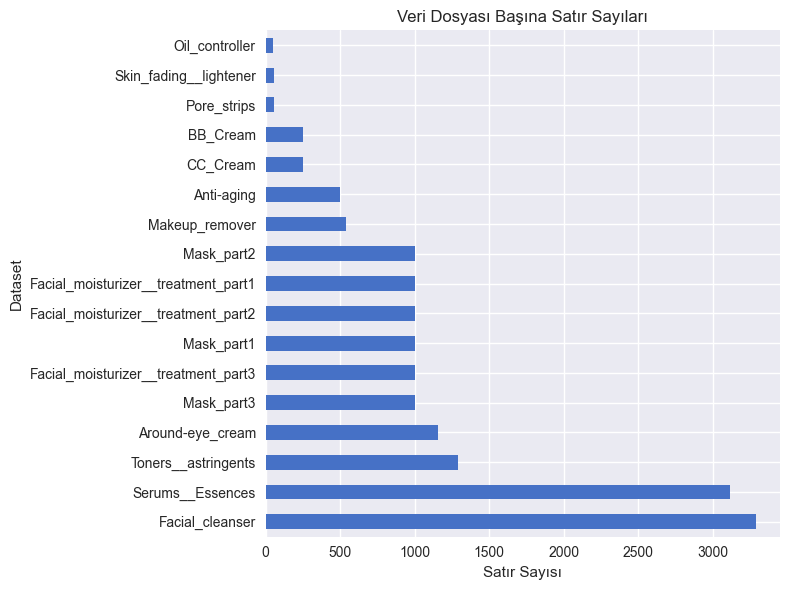

In [5]:

ax = summary_df.plot(kind='barh', x='dataset', y='satir_sayisi', figsize=(8, 6), legend=False, color='#4671C6')
ax.set_xlabel('Satır Sayısı')
ax.set_ylabel('Dataset')
ax.set_title('Veri Dosyası Başına Satır Sayıları')
plt.tight_layout()
plt.show()


## 2. Şema Uyumlama ve Kolon İncelemesi

In [6]:

aligned_frames = data_pipeline.harmonise_columns(raw_frames)
for frame in aligned_frames.values():
    if 'category' in frame.columns:
        frame['category'] = frame['category'].apply(data_pipeline.normalise_category)

all_columns = sorted({col for frame in aligned_frames.values() for col in frame.columns})
presence_data = []
for name, frame in aligned_frames.items():
    presence_flags = [1 if frame[col].astype(bool).any() else 0 for col in all_columns]
    presence_data.append(presence_flags)
columns_matrix = pd.DataFrame(presence_data, columns=all_columns, index=aligned_frames.keys())
columns_matrix


,category,id,ingredients,name,product_url,source_file,status
Anti-aging,1,1,1,1,1,1,0
Around-eye_cream,1,1,1,1,1,1,1
BB_Cream,1,1,1,1,1,1,0
CC_Cream,1,1,1,1,1,1,0
Facial_cleanser,1,1,1,1,1,1,1
Facial_moisturizer__treatment_part1,1,1,1,1,1,1,0
Facial_moisturizer__treatment_part2,1,1,1,1,1,1,0
Facial_moisturizer__treatment_part3,1,1,1,1,1,1,0
Makeup_remover,1,1,1,1,1,1,0
Mask_part1,1,1,1,1,1,1,0


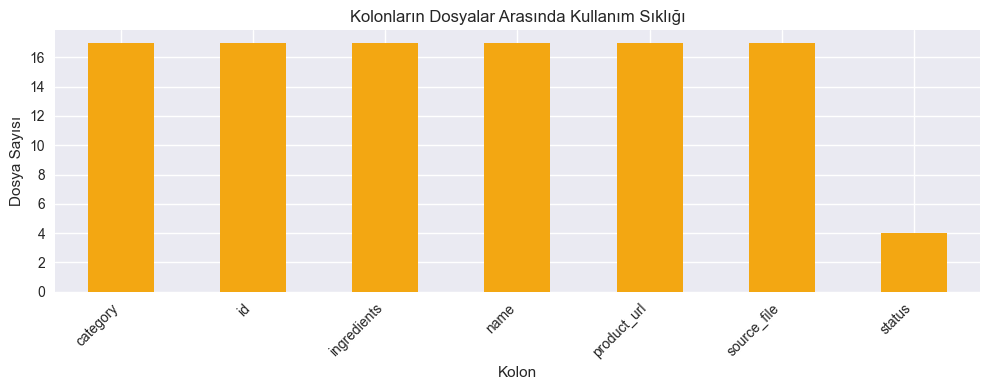

In [7]:

ax = columns_matrix.sum(axis=0).sort_values(ascending=False).plot(kind='bar', figsize=(10, 4), color='#F3A712')
ax.set_title('Kolonların Dosyalar Arasında Kullanım Sıklığı')
ax.set_ylabel('Dosya Sayısı')
ax.set_xlabel('Kolon')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 3. Veri Birleştirme, Karıştırma ve ID Yeniden İnşası

In [8]:

combined = data_pipeline.combine_frames(aligned_frames.values())
combined = combined.drop(columns=['id'], errors='ignore')
combined = combined.rename(columns={'ingredients': 'ingredients_raw'})
if 'category' in combined.columns:
    combined['category'] = combined['category'].apply(data_pipeline.normalise_category)
combined = combined.sample(frac=1.0, random_state=42).reset_index(drop=True)
combined = data_pipeline.rebuild_product_ids(combined)
combined[['product_id', 'category', 'name', 'source_file']].head()


,product_id,category,name,source_file
0,0,facial cleanser,Grace + Tonic Botanical Beauty Cleansing Mud (2018 formulation),Facial_cleanser.csv
1,1,facial cleanser,Murad Hydration AHA/BHA Exfoliating Cleanser,Facial_cleanser.csv
2,2,facial cleanser,Purity One Step Mattifying Facial Cleanser,Facial_cleanser.csv
3,3,facial cleanser,"Every Man Jack, Skin. Volcanic Clay 2 in 1 Mask + Cleanser (2020 formulation)",Facial_cleanser.csv
4,4,makeup remover,Pond's Deep Cleanser Make Up Remover Cold Cream (2019 formulation),Makeup_remover.csv


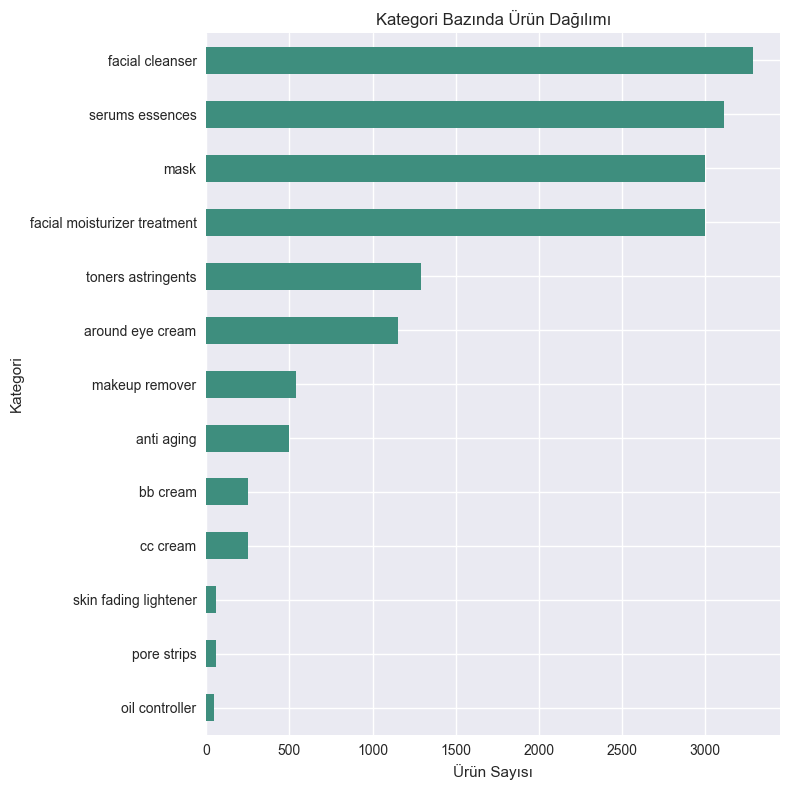

In [9]:

category_counts = combined['category'].value_counts().sort_values(ascending=True)
ax = category_counts.plot(kind='barh', figsize=(8, 8), color='#3E8E7E')
ax.set_xlabel('Ürün Sayısı')
ax.set_ylabel('Kategori')
ax.set_title('Kategori Bazında Ürün Dağılımı')
plt.tight_layout()
plt.show()


## 4. Ingredient Normalizasyonu

In [10]:

normalised_df, ingredient_map = data_pipeline.build_ingredient_lists(combined)
ingredient_map, canonical_lookup = data_pipeline.standardise_ingredient_map(ingredient_map)
normalised_df = data_pipeline.apply_canonical_to_products(normalised_df, canonical_lookup)
preview = normalised_df[['product_id', 'ingredients_raw', 'ingredients_normalised', 'ingredient_count']].head(5)
preview


,product_id,ingredients_raw,ingredients_normalised,ingredient_count
0,0,"WATER, ALOE BARBADENSIS LEAF JUICE*, CAPRYLYL/CAPRYL GLUCOSIDE, KAOLIN, HELIANTHUS ANNUUS (SUNFLOWER) SEED OIL*, GLY...",water | aloe barbadensis leaf juice | caprylyl capryl glucoside | kaolin | helianthus annuus sunflower seed oil | gl...,24
1,1,"Water (Aqua), Sodium Laureth Sulfate, Cocamidopropyl Betaine, Jojoba Esters, Acrylates Copolymer, Glycol Stearate, B...",water | sodium laureth sulfate | cocamidopropyl betaine | jojoba esters | acrylates copolymer | glycol stearate | bu...,21
2,2,"AQUA/WATER/EAU, SODIUM LAUROAMPHOACETATE, SODIUM TRIDECETH SULFATE, ACRYLATES COPOLYMER, POLYSORBATE 20, SODIUM C14-...",water | sodium cocoamphoacetate | sodium trideceth sulfate | acrylates copolymer | polysorbate 20 | sodium c14-16 ol...,22
3,3,"WATER/AQUA/EAU, COCAMIDOPROPYL BETAINE, SODIUM C14-16 OLEFIN SULFONATE, ALOE BARBADENSIS (ALOE VERA) LEAF JUICE, GLY...",water | cocamidopropyl betaine | sodium c14-16 olefin sulfonate | aloe barbadensis aloe vera leaf juice | glycerin |...,10
4,4,": MINERAL OIL, WATER (AGUA), CERESIN, BEESWAX, TRIETHANOLAMINE, BEHENIC ACID, CETYL ALCOHOL, PHENOXYETHANOL, CETETH-...",mineral oil | water | ceresin | beeswax | triethanolamine | behenic acid | cetyl alcohol | phenoxyethanol | ceteth-2...,13


In [11]:
ingredient_map[['original', 'normalised', 'canonical']].sample(10, random_state=24)

,original,normalised,canonical
81650,*Lactobacillus/Taraxacum Officinale (Dandelion) Rhizome/Root Ferment Filtrate,lactobacillus taraxacum officinale dandelion rhizome root ferment filtrate,lactobacillus taraxacum officinale dandelion rhizome root ferment filtrate
183417,Viola Odorata Flower/Leaf Extract,viola odorata flower leaf extract,viola odorata flower leaf extract
217672,ETHYLHEXYLGLYCERIN,ethylhexylglycerin,ethylhexylglycerin
187339,NIACINAMIDE,niacinamide,niacinamide
246682,CITRIC ACID,citric acid,citric acid
147045,SACCHARIDE ISOMERATE,saccharide isomerate,saccharide isomerate
6057,CITRIC ACID,citric acid,citric acid
283546,dimethicone crosspolymer,dimethicone crosspolymer,dimethicone crosspolymer
215503,Ferula Assa Foetida Root Extract,ferula assa foetida root extract,ferula assa foetida root extract
28267,LEUCONOSTOC/RADISH ROOT FERMENT FILTRATE,leuconostoc radish root ferment filtrate,leuconostoc radish root ferment filtrate


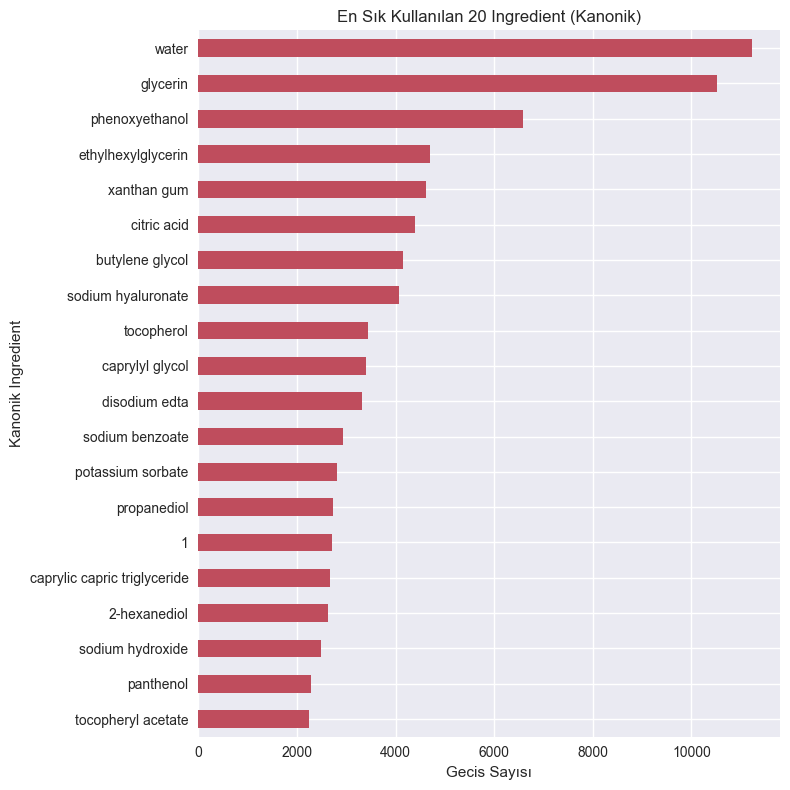

In [12]:

top_ingredients = (
    ingredient_map.groupby('canonical')['product_id']
    .nunique()
    .sort_values()
    .tail(20)
)
ax = top_ingredients.plot(kind='barh', figsize=(8, 8), color='#BF4D5D')
ax.set_xlabel('Gecis Sayısı')
ax.set_ylabel('Kanonik Ingredient')
ax.set_title('En Sık Kullanılan 20 Ingredient (Kanonik)')
plt.tight_layout()
plt.show()


## 5. Çıktıların Kaydedilmesi

In [13]:

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
products_path = OUTPUT_DIR / 'unified_products.csv'
map_path = OUTPUT_DIR / 'ingredient_normalisation_map.csv'
unique_path = OUTPUT_DIR / 'unique_ingredients.csv'

unique_ingredients = (
    ingredient_map.groupby('canonical')
    .agg(
        product_frequency=('product_id', 'nunique'),
        variant_count=('normalised', 'nunique'),
    )
    .sort_values(['product_frequency', 'canonical'], ascending=[False, True])
    .reset_index()
    .rename(columns={'canonical': 'ingredient'})
)

normalised_df.to_csv(products_path, index=False)
ingredient_map.to_csv(map_path, index=False)
unique_ingredients.to_csv(unique_path, index=False)

sizes = pd.DataFrame([
    ('unified_products.csv', products_path.stat().st_size / 1024 / 1024),
    ('ingredient_normalisation_map.csv', map_path.stat().st_size / 1024 / 1024),
    ('unique_ingredients.csv', unique_path.stat().st_size / 1024 / 1024),
], columns=['dosya', 'boyut_mb'])
sizes


,dosya,boyut_mb
0,unified_products.csv,36.476480
1,ingredient_normalisation_map.csv,24.638234
2,unique_ingredients.csv,0.688465


## 6. Son Kontroller

In [14]:

checks = {
    'benzersiz_product_id': normalised_df['product_id'].is_unique,
    'product_id_sifirdan_basliyor': normalised_df['product_id'].min() == 0,
    'product_id_surekliligi': normalised_df['product_id'].max() + 1 == len(normalised_df),
    'bos_ingredient_sayisi': int((normalised_df['ingredient_count'] == 0).sum()),
}
summary = pd.Series(checks).to_frame('deger')
summary


,deger
benzersiz_product_id,True
product_id_sifirdan_basliyor,True
product_id_surekliligi,True
bos_ingredient_sayisi,3


In [15]:

normalised_df['ingredient_count'].describe()


count    16556.000000
mean        22.049408
std         12.693262
min          0.000000
25%         13.000000
50%         21.000000
75%         29.000000
max        151.000000
Name: ingredient_count, dtype: float64

## 7. Benzersiz Ingredient Listesi

In [16]:
unique_ingredients

,ingredient,product_frequency,variant_count
0,water,11236,17
1,glycerin,10524,7
2,phenoxyethanol,6587,21
3,ethylhexylglycerin,4701,17
4,xanthan gum,4609,8
...,...,...,...
18013,zingiber officinale root oil ginger root oil,1,1
18014,zingiber officinale root oil zingiber officinale ginger root oil,1,1
18015,zingiber officinale roscoe ginger root,1,1
18016,zingiber officinale water zingiber officinale ginger water,1,1


In [17]:
pd.DataFrame({'metrik': ['benzersiz_ingredient_sayisi'], 'deger': [len(unique_ingredients)]})

,metrik,deger
0,benzersiz_ingredient_sayisi,18018
